# Session 3: GET a Taxi with Temporal Difference Learning

## Colab Setup

In [1]:
# #uncomment only if you're running from google colab
# !git clone https://github.com/Datatouille/rl-workshop
# !mv rl-workshop/* .
# !ls
# !pip install gym #For full installations, see https://github.com/openai/gym#installation

## Imports

In [2]:
%matplotlib inline

import gym
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import pickle
from tqdm import trange
import seaborn as sns
import pandas as pd
from random import random
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

#cross check with our solutions once you finish
from solutions.agents import TaxiAgent, BJAgent

MODEL_PATH = 'models/'

## Recap

### Monte Carlo Methods

For an arbitrary number of episodes, do:
* **Step 1** Run the episode until the end and get a list of transitions $[(s_0,a_0,r_1,s_1), (s_1,a_1,r_2,s_2),...]$ with a random policy
* **Step 2** Loop through those transition tuples,
    * **Step 2.1** Count number of times a state-action pair appears in the current episode `n_q` (only if it is the first time we saw this state-action pair)
    * **Step 2.2** Calculate discounted rewards from the current transition until the end `g` (only if it is the first time we saw this state-action pair)
    * **Step 2.3** Add learning rate times the difference between the discounted rewards we just calculate `g` and the existing action value `q`
* **Step 3** Update the current policy after a few episodes or after we have trained all episodes

**Conceptual Assignment** Is this good enough? How can we do better?

In [3]:
def mc_control_glie(self,n_episode=500000,lr=0.,update_every=1):
    for t in trange(n_episode):
        traversed = []
        e = self.get_epsilon(t)
        
        #step 1
        transitions = self.run_episode(e)
        states,actions,rewards,next_states,dones = zip(*transitions)

        #step 2
        for i in range(len(transitions)):
            traversed.append((states[i],actions[i]))
            #step 2.1
            self.n_q[states[i]][actions[i]]+=1
            #step 2.2
            discounts = np.array([self.gamma**j for j in range(len(transitions)+1)])
            g = sum(rewards[i:]*discounts[:-(1+i)])
            #step 2.3
            alpha = lr if lr > 0 else (1/self.n_q[states[i]][actions[i]])
            self.q[states[i]][actions[i]]+= alpha * (g - self.q[states[i]][actions[i]])

        #step 3
        if t % int(update_every * n_episode - 1)==0:
            self.update_policy_q()

    self.update_policy_q()

## What Can We Improve About Monte Carlo: Temporal Difference Learning

Temporal difference (TD) learning is another value-based method for solving a reinforcement learning problem. Main differences between this and the Monte Carlo method we learned are that:

* TD updates the Q-values at every time step; we do not need to run an entire episode beforehand
* TD updates the policy at every timestep

That is probably why it is called **temporal difference** learning.

## [Taxi-v2](https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py)

Taxi-v2 is a reinforcment learning environment described in [Dietterich (2000)](https://arxiv.org/abs/cs/9905014) to demonstrate some issues with hierarchical reinforcement learning. The environment features a 5x5 grid with four locations denoted as red, blue, green and yellow. Our agent is a taxi started at any random position. The goal of the environment is to go pick up a passenger at an arbitrary location then send them to their destination as fast as possible.

In [4]:
env = gym.make('Taxi-v2')

**Coding Assignment** Find out what are the following elements

* States:
* Actions:
* Rewards: 

In [5]:
"""
Use this cell to try execute the following functions:
* env.reset() - reset the environment and return the current state
* env.step(action) - take an action at the current state; returns a tuple of (state, reward, done, info)
"""

'\nUse this cell to try execute the following functions:\n* env.reset() - reset the environment and return the current state\n* env.step(action) - take an action at the current state; returns a tuple of (state, reward, done, info)\n'

### Observation Space (State Space)

The state is a single integer from 0 to 499. This is a result of all combinations of:
* 25 taxi positions
* 5 possible locations of the passenger (including the case when the passenger is the taxi)
* 4 destination locations. 
    

In [6]:
env.observation_space

Discrete(500)

In [7]:
env.reset()

64

### Action Space

There are 6 discrete deterministic actions:
- 0: move south
- 1: move north
- 2: move east 
- 3: move west 
- 4: pickup passenger
- 5: dropoff passenger

In [8]:
env.action_space

Discrete(6)

### Reward

* -1 for each action; to finish the task as fast as possible
* +20 for delivering passenger
* -10 for doing `pickup` (4) and `dropoff` (5) illegally
* No penalty for illegal move (the taxi will remain at the same tile)

In [9]:
print(f'State: {env.reset()}')
next_tuple = env.step(0)
print(f'Action: 0, Next state: {next_tuple[0]}, Reward: {next_tuple[1]}')

State: 367
Action: 0, Next state: 467, Reward: -1


In [10]:
env.step(0)

(467, -1, False, {'prob': 1.0})

### Rendering

- blue: passenger
- magenta: destination
- yellow: empty taxi
- green: full taxi
- other letters: locations

In [11]:
env.render(mode = 'human')

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)


In [12]:
env = gym.make('Taxi-v2').env

In [13]:
frames = []
illegal_moves = 0
illegal_others = 0
cumu_reward = 0

#get initial state
state = env.reset()

while True:
    #random action
    action = env.action_space.sample()
    
    #step the environment to get (next_state, reward, done, info)
    next_state,reward,done,info =  env.step(action)
    
    #keep records
    if state==next_state: illegal_moves+=1
    if reward==-10: illegal_others+=1
    cumu_reward+=reward
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward,
        'cumulative_reward': cumu_reward,
        'illegal_moves': illegal_moves,
        'illegal_others': illegal_others
        })
    
    #set current state to next state
    state = next_state
    
    #stop game if done; there's a bug with taxi-v2 that cuts your game over if you have not solved it in 200 timesteps
    if done: break
#     if reward==20: break

In [14]:
#stolen from https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/
from IPython.display import clear_output
import time

def print_frames(frames,wait_time=0.2):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'].getvalue())
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        print(f"Cumulative Reward: {frame['cumulative_reward']}")
        print(f"Illegal Moves: {frame['illegal_moves']}")
        print(f"Illegal Others: {frame['illegal_others']}")
        time.sleep(wait_time)

In [15]:
len(frames)

151

In [16]:
# print_frames(frames[:200])

### Human Play

Play a couple of rounds with your own natural neural networks to get a hang of the environment.

In [17]:
state = env.reset()
env.render()

cumu_reward = 0

while True:
    action = int(input('Choose action: '))
    state, reward, done, info = env.step(action)
    cumu_reward+=reward
    clear_output(wait=False)
    env.render()
    print(f'Reward: {reward}')
    print(f'Cumulative Reward: {cumu_reward}')
    if reward==20: break

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Reward: 20
Cumulative Reward: 9


- 0: Down
- 1: Up
- 2: Right
- 3: Left
- 4: Pickup
- 5: Dropoff

### Computer Play

Our benchmark will be the final cumulative reward, from now on called `score`, at the end of an episode over time. For instance, when we do 1,000 episodes, as our agent becomes smarter, the cumulative rewards should get better and better. OpenAI uses 100-episode average score as their benchmark for "solving" the environment. **The solving score for this environment is 8.5.**

**Concept Assignment** Why is it a bad idea to use Monte Carlo method for this environment?

In [18]:
scores = []
ts = []
illegal_moves = []
illegal_others = []
moving_scores = []
moving_nb = 100
solved_score = 8.5
start_time = datetime.now()

for i in trange(200):
    #for the record
    score = 0
    t= 0
    illegal_move = 0
    illegal_other = 0
    
    #initiate state
    state = env.reset()
    while True:
        
        #get action
        action = env.action_space.sample()
        
        #step environment
        next_state, reward, done, info = env.step(action)
        
        #records
        score+=reward
        t+=1
        if state==next_state: illegal_move+=1
        if reward==-10: illegal_other+=1
        
        #move to next state
        state = next_state
        
        #end if drop off at destination
        if reward==20: break
            
    #record
    scores.append(score)
    ts.append(t)
    illegal_moves.append(illegal_move)
    illegal_others.append(illegal_other)
    
    if i > moving_nb:
        moving_score = np.mean(scores[i-moving_nb:i])
        moving_scores.append(moving_score)
    else:
        moving_scores.append(0)
        
    #break if solved
    if moving_scores[-1] > solved_score: 
        print(f'Solved at Play {i}: {datetime.now() - start_time} Moving average: {moving_scores[-1]}')
        break

100%|██████████| 200/200 [00:04<00:00, 43.44it/s]


100-episode average score: -8008.72


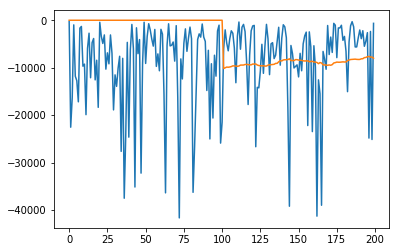

In [19]:
plt.plot(scores)
plt.plot(moving_scores)
print(f'100-episode average score: {moving_scores[-1]}')

100-episode average timesteps: 2550.81


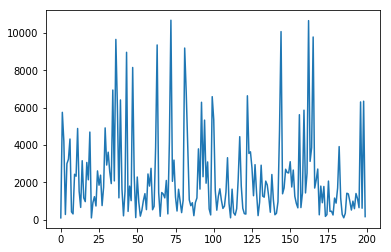

In [20]:
plt.plot(ts)
print(f'100-episode average timesteps: {np.mean(ts[:-100])}')

Illegal moves: 92; Illegal drop-offs/pickups: 56


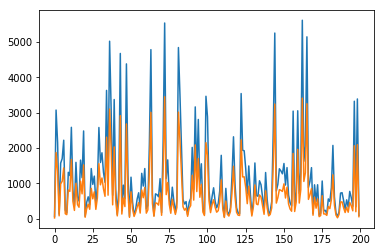

In [21]:
plt.plot(illegal_moves)
plt.plot(illegal_others)
print(f'Illegal moves: {illegal_moves[-1]}; Illegal drop-offs/pickups: {illegal_others[-1]}')

## What Does A TD Agent Order at A Mexican Restaurant?

SARSA is the most basic of temporal difference learning. It got its name from the tuples we used for the learning:

$$S_0 \rightarrow A_0 \rightarrow R_1 \rightarrow S_1 \rightarrow A_1 \rightarrow R_2 \rightarrow S_2 \rightarrow ... \rightarrow S_{t-1} \rightarrow A_{t-1} \rightarrow R_t \rightarrow S_{t}$$

Remember in Monte Carlo, you estimate the action values by:

$$G_t = R_{t} + \gamma R_{t+1} + ... $$

$$Q(s_t,a_t) = \frac{\sum_{i=1}^{N(s_t,a_t)} G_i}{N(s_t,a_t)} = E[G(s_t,a_t)]$$

where:
* $G_t$ is discounted rewards
* $R_t$ is the reward for each time step
* $Q(s_t,a_t)$ is the action value for that state-action pair
* $N(s_t,a_t)$ is the number of time we have seen that state-action pair

We need to run the entire episode before updating Q because we need to calculate:

$$G_t = R_{t} + \gamma R_{t+1} + \gamma^2 R_{t+2} + \gamma^3 R_{t+3} + ... $$

But actually

$$G_{t+1} = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ...$$

$$G_t = R_t + \gamma (R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ...) = R_t + \gamma (G_{t+1}) = R_{t+1} + \gamma Q(s_{t+1},a_{t+1})$$

And since action value $Q(s,a)$ is **expected** discounted rewards, we can substitute $Q(s_{t+1},a_{t+1})$ for $G_{t+1}$. And with each time step, we update the action values as:

$$Q(s_t,a_t) = Q(s_t,a_t) + \alpha (R_{t+1} + \gamma Q(s_{t+1},a_{t+1}) - Q(s_t,a_t))$$

where $\alpha$ is the learning rate

## Fill in The Code

In [43]:
# import numpy as np
# from collections import defaultdict
# import sys
# import random
# from tqdm import trange

# class TaxiAgent:
#     def __init__(self, env, gamma = 0.8, alpha = 1e-1,
#                  start_epsilon = 1, end_epsilon = 1e-2, epsilon_decay = 0.999):
        
#         self.env = env
#         self.n_action = self.env.action_space.n
#         self.gamma = gamma
#         self.alpha = alpha
        
#         #action values
#         self.q = defaultdict(lambda: np.zeros(self.n_action)) #action value
        
#         #epsilon greedy parameters
#         self.start_epsilon = start_epsilon
#         self.end_epsilon = end_epsilon
#         self.epsilon_decay = epsilon_decay

#     #get epsilon
#     def get_epsilon(self,n_episode):
#         epsilon = max(self.start_epsilon * (self.epsilon_decay ** n_episode), self.end_epsilon)
#         return(epsilon)
    
#     #select action based on epsilon greedy
#     def select_action(self,state,epsilon):
#         #implicit policy; if we have action values for that state, choose the largest one, else random
#         best_action = np.argmax(self.q[state]) if state in self.q else self.env.action_space.sample()
#         if random.random() > epsilon:
#             action = best_action
#         else:
#              action = self.env.action_space.sample()
#         return(action)
    
#     def sarsa_update(self, state, action, reward, next_state, n_episode):
#         #get next action
#         next_action = self.select_action(next_state, self.get_epsilon(n_episode)) 
#         #get new q
#         new_q = reward + (self.gamma * self.q[next_state][next_action])
#         #calculate update equation
#         self.q[state][action] = self.q[state][action] + (self.alpha * (new_q - self.q[state][action]))
        
#     def sarsa_max_update(self, state, action, reward, next_state):
#         """
#         Implement your code here
#         """
        
#         new_q = reward + (self.gamma * np.max(self.q[next_state]))
#         self.q[state][action] = self.q[state][action] + (self.alpha * (new_q - self.q[state][action]))
        
#     def sarsa_expected_update(self, state, action, reward, next_state, n_episode):
#         #get next action
#         next_action = self.select_action(next_state, self.get_epsilon(n_episode)) 
#         #get current epsilon
#         eps = self.get_epsilon(n_episode)
#         #get q value of random portion
#         random_q = eps * np.sum((1/self.n_action) * self.q[next_state])
#         #get q value of best action
#         best_q = (1-eps) * self.q[next_state][next_action]
#         #get new q
#         new_q = reward + self.gamma * (random_q+best_q)
#         #calculate update equation
#         self.q[state][action] = self.q[state][action] + (self.alpha * (new_q - self.q[state][action]))

## SARSA

For every **timestep**
* **Step 1** Given state $s_t$, choose an action $a_t$ using epsilon greedy policy
* **Step 2** Take that action and observe next state ($s_{t+1}$) and reward ($r_{t+1}$)
* **Step 3** Update the action value $Q(s_t,a_t)$ using the equation above

In [28]:
a = TaxiAgent(env, gamma = 0.8, alpha = 1e-1,
                 start_epsilon = 1, end_epsilon = 1e-2, epsilon_decay = 0.999)

In [29]:
scores = []
ts = []
illegal_moves = []
illegal_others = []
moving_scores = []

moving_nb = 100
solved_score = 8.5
start_time = datetime.now()

for i in trange(100000):
    #for the record
    score = 0
    t= 0
    illegal_move = 0
    illegal_other = 0
    
    #initiate state
    state = env.reset()
    while True:
        
        #get action
        action = a.select_action(state, a.get_epsilon(i))
        
        #step environment
        next_state, reward, done, info = env.step(action)
        
        #update agent
        a.sarsa_update(state, action, reward, next_state, i)
        
        #records
        score+=reward
        t+=1
        if state==next_state: illegal_move+=1
        if reward==-10: illegal_other+=1
        
        #move to next state
        state = next_state
        
        #end if drop off at destination
        if reward==20: break
            
    #record
    scores.append(score)
    ts.append(t)
    illegal_moves.append(illegal_move)
    illegal_others.append(illegal_other)
    
    if i > moving_nb:
        moving_score = np.mean(scores[i-moving_nb:i])
        moving_scores.append(moving_score)
    else:
        moving_scores.append(0)
        
    #break if solved
    if moving_scores[-1] > solved_score: 
        print(f'Solved at Play {i}: {datetime.now() - start_time} Moving average: {moving_scores[-1]}')
        break

 18%|█▊        | 17924/100000 [00:24<01:49, 746.31it/s]

Solved at Play 18112: 0:00:24.065268 Moving average: 8.55


 18%|█▊        | 17924/100000 [00:40<03:03, 448.08it/s]

100-episode average score: 8.55


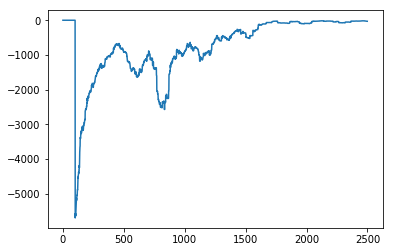

In [32]:
plt.plot(moving_scores[:2500])
print(f'100-episode average score: {moving_scores[-1]}')

In [ ]:
plt.plot(ts)
print(f'100-episode average timesteps: {np.mean(ts[:-100])}')

In [ ]:
plt.plot(illegal_moves)
plt.plot(illegal_others)
print(f'Illegal moves: {illegal_moves[-1]}; Illegal drop-offs/pickups: {illegal_others[-1]}')

## Q-learning aka SARSAMAX

Q-learning or SARSAMAX is perhaps the most well-known RL algorithm due to Deepminds' [Playing Atari with Deep Reinforcement Learning](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf) paper in 2013. There are some significant contributions made by that paper such as using deep learning as function approximation instead of a dictionary, experience replay, and fixed target for learning. But the principle of the learning remains largely the same as the algorithm we will learn today.

For every **timestep**
* **Step 1** Given state $s_t$, choose an action $a_t$ using epsilon greedy policy
* **Step 2** Update the action value $Q(s_t,a_t)$ using the following equation:

$Q(s_t,a_t) = Q(s_t,a_t) + \alpha (R_{t+1} + \gamma max_{a}Q(s_{t+1},a) - Q(s_t,a_t))$

where $max_{a}Q(s_{t+1},a)$ is the highest action value given state $s_{t+1}$. 

This is very similar to SARSA except for the fact that we will always choose the best action value as opposed to epsilon-greedy action selection of SARSA. For this reason, SARSA is called **on-policy** and Q-learning **off-policy**.

**Coding Assignment** Implement Q-learning in `sarsa_max_update` method

In [38]:
a = TaxiAgent(env, gamma = 0.8, alpha = 1e-1,
                 start_epsilon = 1, end_epsilon = 1e-2, epsilon_decay = 0.999)

In [39]:
scores = []
ts = []
illegal_moves = []
illegal_others = []
moving_scores = []
moving_nb = 100
solved_score = 8.5
start_time = datetime.now()

for i in range(100000):
    #for the record
    score = 0
    t= 0
    illegal_move = 0
    illegal_other = 0
    
    #initiate state
    state = env.reset()
    while True:
        
        #get action
        action = a.select_action(state, a.get_epsilon(i))
        
        #step environment
        next_state, reward, done, info = env.step(action)
        
        #update agent
        a.sarsa_max_update(state, action, reward, next_state)
        
        #records
        score+=reward
        t+=1
        if state==next_state: illegal_move+=1
        if reward==-10: illegal_other+=1
        
        #move to next state
        state = next_state
        
        #end if drop off at destination
        if reward==20: break
            
    #record
    scores.append(score)
    ts.append(t)
    illegal_moves.append(illegal_move)
    illegal_others.append(illegal_other)
    
    if i > moving_nb:
        moving_score = np.mean(scores[i-moving_nb:i])
        moving_scores.append(moving_score)
    else:
        moving_scores.append(0)
        
    #break if solved
    if moving_scores[-1] > solved_score: 
        print(f'Solved at Play {i}: {datetime.now() - start_time} Moving average: {moving_scores[-1]}')
        break

Solved at Play 4438: 0:00:05.150673 Moving average: 8.56


100-episode average score: 8.56


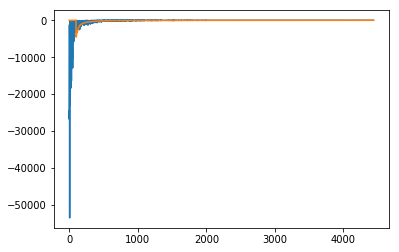

In [40]:
plt.plot(scores)
plt.plot(moving_scores)
print(f'100-episode average score: {moving_scores[-1]}')

100-episode average timesteps: 56.011984328186216


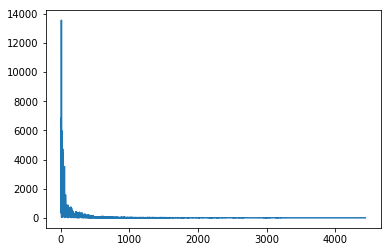

In [41]:
plt.plot(ts)
print(f'100-episode average timesteps: {np.mean(ts[:-100])}')

Illegal moves: 1; Illegal drop-offs/pickups: 0


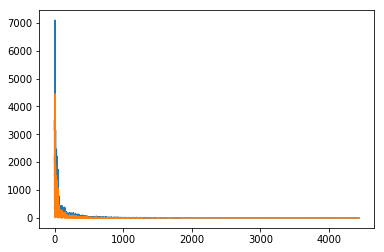

In [42]:
plt.plot(illegal_moves)
plt.plot(illegal_others)
print(f'Illegal moves: {illegal_moves[-1]}; Illegal drop-offs/pickups: {illegal_others[-1]}')

## Expected SARSA

Expected SARSA is another way we can update the Q values, not with maximum action values but with all the actions value weighted by their probability (in our case of the epsilon-greedy policy).

For every **timestep**
* **Step 1** Given state $s_t$, choose an action $a_t$ using epsilon greedy policy
* **Step 2** Update the action value $Q(s_t,a_t)$ using the following equation:

$$Q(s_t,a_t) = Q(s_t,a_t) + \alpha (R_{t+1} + \gamma \sum_{a}\pi(a|s_{t+1})Q(s_{t+1},a) - Q(s_t,a_t))$$

where $\pi(a|s_{t+1})$ is the probability of taking an action $a$.

In [45]:
scores = []
ts = []
illegal_moves = []
illegal_others = []
moving_scores = []
moving_nb = 100
solved_score = 8.5
start_time = datetime.now()

for i in range(100000):
    #for the record
    score = 0
    t= 0
    illegal_move = 0
    illegal_other = 0
    
    #initiate state
    state = env.reset()
    while True:
        
        #get action
        action = a.select_action(state, a.get_epsilon(i))
        
        #step environment
        next_state, reward, done, info = env.step(action)
        
        #update agent
        a.sarsa_expected_update(state, action, reward, next_state, i)
        
        #records
        score+=reward
        t+=1
        if state==next_state: illegal_move+=1
        if reward==-10: illegal_other+=1
        
        #move to next state
        state = next_state
        
        #end if drop off at destination
        if reward==20: break
            
    #record
    scores.append(score)
    ts.append(t)
    illegal_moves.append(illegal_move)
    illegal_others.append(illegal_other)
    
    if i > moving_nb:
        moving_score = np.mean(scores[i-moving_nb:i])
        moving_scores.append(moving_score)
    else:
        moving_scores.append(0)
        
    #break if solved
    if moving_scores[-1] > solved_score: 
        print(f'Solved at Play {i}: {datetime.now() - start_time} Moving average: {moving_scores[-1]}')
        break

Solved at Play 2767: 0:00:02.931696 Moving average: 8.51


100-episode average score: 8.51


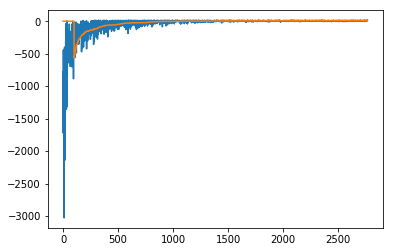

In [46]:
plt.plot(scores)
plt.plot(moving_scores)
print(f'100-episode average score: {moving_scores[-1]}')

100-episode average timesteps: 43.06634182908546


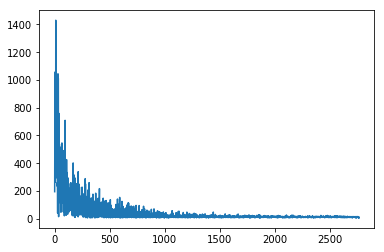

In [47]:
plt.plot(ts)
print(f'100-episode average timesteps: {np.mean(ts[:-100])}')

Illegal moves: 1; Illegal drop-offs/pickups: 0


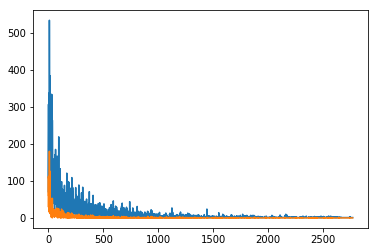

In [48]:
plt.plot(illegal_moves)
plt.plot(illegal_others)
print(f'Illegal moves: {illegal_moves[-1]}; Illegal drop-offs/pickups: {illegal_others[-1]}')

## See A Smart Agent Play

In [62]:
frames = []
illegal_moves = 0
illegal_others = 0
cumu_reward = 0

#get initial state
state = env.reset()

while True:
    #best action
    action = a.select_action(state, a.get_epsilon(1e6))
    
    #step the environment to get (next_state, reward, done, info)
    next_state,reward,done,info =  env.step(action)
    
    #keep records
    if state==next_state: illegal_moves+=1
    if reward==-10: illegal_others+=1
    cumu_reward+=reward
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward,
        'cumulative_reward': cumu_reward,
        'illegal_moves': illegal_moves,
        'illegal_others': illegal_others
        })
    
    #set current state to next state
    state = next_state
    
    #stop game if done; there's a bug with taxi-v2 that cuts your game over if you have not solved it in 200 timesteps
    if reward==20: break

In [63]:
len(frames)

14

In [65]:
print_frames(frames)

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 14
State: 16
Action: 5
Reward: 20
Cumulative Reward: 7
Illegal Moves: 1
Illegal Others: 0


## Coding Assignment

The OpenAI scoreboard lists 9.7 as the high score. This requires you to do some hyperparameter tuning over time of gamma, alpha and epsilon. Try to implement `get_alpha` and `get_gamma` methods in addition to `get_epsilon` and increase/decrease your hyperparameters as the training goes on. Here are some hints:

* `gamma`: you would want to focus more on near-term rewards as time goes on as your agent is more aware of the action values of the states
* `alpha`: you would want to learn more slowly as time goes on as your agent has already accumulated a lot of knowledge about the environment
* `epsilon`: you would want to do less random action as time goes on as your best actions are probably really best.

<img src="img/taxi_scores.PNG" alt="OpenAI Learderboard" />

## Challenges

Solve an environment with continuous states using discretization, tile coding, or other advanced methods

* Acrobat-v1
* MountainCar-v0
* CartPole-v0
* LunarLander-v2
    
Points to consider
* What are other ways of handling continuous states? (See tile coding)
* What are the state space, action space, and rewards of the environment?
* What algorithms did you use to solve the environment and why?
* How many episodes did you solve it in? Can you improve the performance? (Tweaking discount factor, learning rate, Monte Carlo vs TD)


## References

* Dietterich, T. G. (2000). Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition. Journal of Artificial Intelligence Research, 13, 227-303. doi:10.1613/jair.639
* Mnih, V., Kavukcuoglu, K., Silver, D., Graves, A., Antonoglou, I., Wierstra, D., and Riedmiller, M.
(Dec 2013). Playing Atari with deep reinforcement learning. Technical Report arXiv:1312.5602
[cs.LG], Deepmind Technologies